In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier
from catboost import Pool, cv
from sklearn.preprocessing import LabelEncoder

C:\Users\herik\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\herik\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\herik\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Ambiente

In [2]:
seed_ = 194
np.random.seed(seed_)

## Carregando e tratando base de dados

In [3]:
df = pd.read_csv('data/df_sem_duplicatas.csv')

In [4]:
df.head()

,descricao,categoria
0,caneta bic cristal,Papelaria
1,caneta bps pilot,Papelaria
2,caneta marcador permanente acrilex ponta dupla,Papelaria
3,caneta retocar madeira branco corcel,Papelaria
4,caneta retroprojetor manter fazer castelo pont...,Papelaria


In [5]:
# Carregando LabelEncoder model
pkl_file = open('models/label_encoder.pkl', 'rb')
le = pickle.load(pkl_file) 
pkl_file.close()

In [6]:
le.fit(df['categoria'])
df['categoria'] = le.transform(df['categoria'])

In [7]:
# Salvando LabelEncoder model

#output = open('models/label_encoder.pkl', 'wb')
#pickle.dump(le, output)
#output.close()

In [8]:
# Capturando targets gerados pelo LabelEncoder
target_names = le.classes_

In [9]:
df.head()

,descricao,categoria
0,caneta bic cristal,3
1,caneta bps pilot,3
2,caneta marcador permanente acrilex ponta dupla,3
3,caneta retocar madeira branco corcel,3
4,caneta retroprojetor manter fazer castelo pont...,3


## Separando em treino e teste

In [10]:
# Separando em variaveis independentes e dependentes
X, y = df.drop('categoria', axis = 1), df['categoria']

In [11]:
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed_)
data_train = pd.concat([X_train, y_train], axis = 1)

In [12]:
# Separando em teste e validação
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = seed_)

In [13]:
# Gerando TF-IDF
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
X_train_tfidf = TfidfVec.fit_transform(X_train['descricao'].tolist())
X_val_tfidf = TfidfVec.transform(X_val['descricao'].tolist())
X_test_tfidf = TfidfVec.transform(X_test['descricao'].tolist())

In [14]:
# Salvando tf-idf como pickle
with open('models/tfidf_catboost.pkl', 'wb') as model_file:
    pickle.dump(TfidfVec, model_file)

In [15]:
df.head()

,descricao,categoria
0,caneta bic cristal,3
1,caneta bps pilot,3
2,caneta marcador permanente acrilex ponta dupla,3
3,caneta retocar madeira branco corcel,3
4,caneta retroprojetor manter fazer castelo pont...,3


## Modelo base Catboost

In [16]:
def report_modelo(modelo, y, pred):
    print("Acurácia: %f" % accuracy_score(y_true = y, y_pred = pred))
    
    # Plotando a matriz de confusão
    cm = confusion_matrix(y, pred)
    cm = pd.DataFrame(cm, index = target_names, columns = target_names)

    plt.figure(figsize = (8, 8))
    sns.heatmap(cm, cmap = "Blues", linecolor = 'black', linewidths = 1, annot = True, \
                fmt = '', xticklabels = target_names, yticklabels = target_names)
    plt.show()
    
    # Imprimindo métricas
    print(classification_report(y_true = y, y_pred = pred, target_names= target_names))

In [17]:
def treinaClassificacao_GridSearchCV(modelo, params_, x_treino, y_treino, x_teste, y_teste,\
                        n_jobs = -1, cv = 5, refit = True, scoring = None, salvar_resultados = False,\
                       report_treino = False, retorna_modelo = False):
    
    # Realizando treinamento baseado no grid informado
    grid = GridSearchCV(modelo, params_, n_jobs = n_jobs, cv = cv, refit = refit, scoring = scoring)
    
    grid.fit(x_treino, y_treino)
    pred = grid.predict(x_teste)
    modelo_ = grid.best_estimator_

    print(grid.best_params_)
    
    # Realizando previsões
    y_test_pred = modelo_.predict(x_teste)
    
    # Gerando report do modelo
    report_modelo(modelo_, y_teste, y_test_pred) 
    
    # Salvando resultados em dataframe caso solicitado
    if salvar_resultados:
        resultados_df = pd.DataFrame(grid.cv_results_)
        
        if retorna_modelo:
            return resultados_df, modelo_
        else:
            resultados_df
        
    if retorna_modelo:
        return modelo_

{}
Acurácia: 0.701789


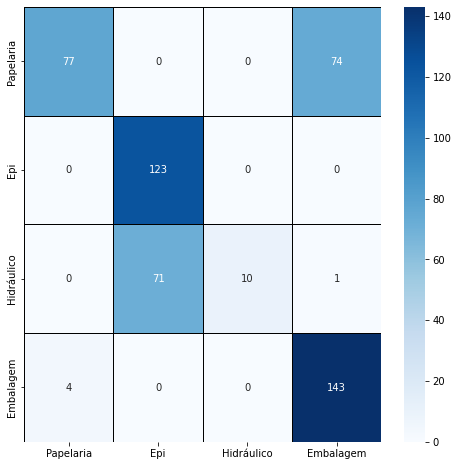

              precision    recall  f1-score   support

   Papelaria       0.95      0.51      0.66       151
         Epi       0.63      1.00      0.78       123
  Hidráulico       1.00      0.12      0.22        82
   Embalagem       0.66      0.97      0.78       147

    accuracy                           0.70       503
   macro avg       0.81      0.65      0.61       503
weighted avg       0.80      0.70      0.65       503

CPU times: total: 30.8 s
Wall time: 13.2 s


In [15]:
%%time

params = {}

# Modelo Base CatBoost Classifier
modelo_cat = CatBoostClassifier(iterations = 50, eval_metric = 'MultiClass', metric_period = 50,\
                                learning_rate = 0.01, verbose = False, random_seed = seed_)

treinaClassificacao_GridSearchCV(modelo_cat, params, X_train_tfidf, y_train, X_test_tfidf, y_test)

## Tuning Catboost

{'iterations': 1000, 'learning_rate': 0.1}
Acurácia: 0.922465


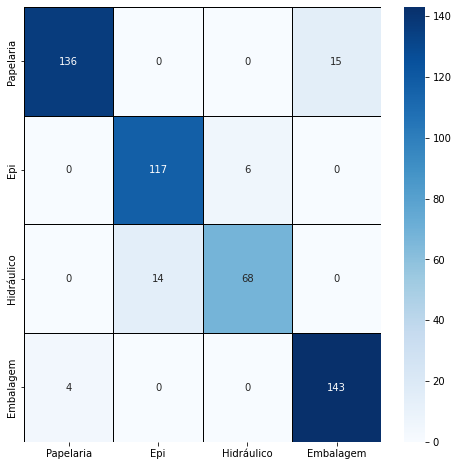

              precision    recall  f1-score   support

   Papelaria       0.97      0.90      0.93       151
         Epi       0.89      0.95      0.92       123
  Hidráulico       0.92      0.83      0.87        82
   Embalagem       0.91      0.97      0.94       147

    accuracy                           0.92       503
   macro avg       0.92      0.91      0.92       503
weighted avg       0.92      0.92      0.92       503

CPU times: total: 9min 33s
Wall time: 8min 35s


In [50]:
%%time

params = {
    'iterations': [50, 100, 500, 1000],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Tuning 01 Catboost
modelo_cat = CatBoostClassifier(eval_metric = 'MultiClass', metric_period = 50,\
                                verbose = False, random_seed = seed_)

treinaClassificacao_GridSearchCV(modelo_cat, params, X_train_tfidf, y_train, X_test_tfidf, y_test)

{'iterations': 1250, 'learning_rate': 0.2}
Acurácia: 0.932406


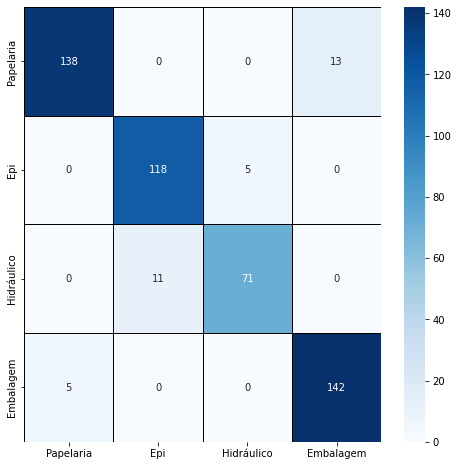

              precision    recall  f1-score   support

   Papelaria       0.97      0.91      0.94       151
         Epi       0.91      0.96      0.94       123
  Hidráulico       0.93      0.87      0.90        82
   Embalagem       0.92      0.97      0.94       147

    accuracy                           0.93       503
   macro avg       0.93      0.93      0.93       503
weighted avg       0.93      0.93      0.93       503

CPU times: total: 11min 30s
Wall time: 10min 6s


In [51]:
%%time

params = {
    'iterations': [750, 1000, 1250],
    'learning_rate': [0.2, 0.1, 0.01]
}

# Tuning 02 Catboost
modelo_cat = CatBoostClassifier(eval_metric = 'MultiClass', metric_period = 50,\
                                verbose = False, random_seed = seed_)

treinaClassificacao_GridSearchCV(modelo_cat, params, X_train_tfidf, y_train, X_test_tfidf, y_test)

C:\Users\herik\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\herik\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\herik\anaconda3\lib\site-packages\catboost\core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\herik\anaconda3\lib\site-packages\catboost\core.py", line 2303, i

{'iterations': 1250, 'learning_rate': 0.2}
Acurácia: 0.932406


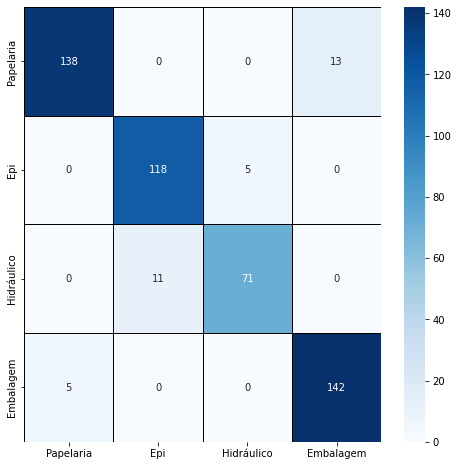

              precision    recall  f1-score   support

   Papelaria       0.97      0.91      0.94       151
         Epi       0.91      0.96      0.94       123
  Hidráulico       0.93      0.87      0.90        82
   Embalagem       0.92      0.97      0.94       147

    accuracy                           0.93       503
   macro avg       0.93      0.93      0.93       503
weighted avg       0.93      0.93      0.93       503

CPU times: total: 11min 38s
Wall time: 23min 25s


In [16]:
%%time

params = {
    'iterations': [1250, 1500, 2000],
    'learning_rate': [0,4, 0.3, 0.2]
}

# Tuning 03 Catboost
modelo_cat = CatBoostClassifier(eval_metric = 'MultiClass', metric_period = 50,\
                                verbose = False, random_seed = seed_)

treinaClassificacao_GridSearchCV(modelo_cat, params, X_train_tfidf, y_train, X_test_tfidf, y_test)

{'depth': 7, 'iterations': 1250, 'learning_rate': 0.2}
Acurácia: 0.936382


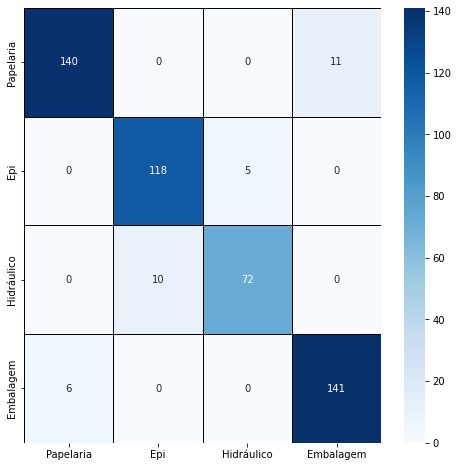

              precision    recall  f1-score   support

   Papelaria       0.96      0.93      0.94       151
         Epi       0.92      0.96      0.94       123
  Hidráulico       0.94      0.88      0.91        82
   Embalagem       0.93      0.96      0.94       147

    accuracy                           0.94       503
   macro avg       0.94      0.93      0.93       503
weighted avg       0.94      0.94      0.94       503

CPU times: total: 24min 15s
Wall time: 19min 53s


In [24]:
%%time

params = {
    'iterations': [1250],
    'learning_rate': [0.2],
    'depth': [6, 7, 8]
}

# Tuning 04 Catboost
modelo_cat = CatBoostClassifier(eval_metric = 'MultiClass', metric_period = 50,\
                                verbose = False, random_seed = seed_)

treinaClassificacao_GridSearchCV(modelo_cat, params, X_train_tfidf, y_train, X_test_tfidf, y_test)

## Salvando modelo

{}
Acurácia: 0.932406


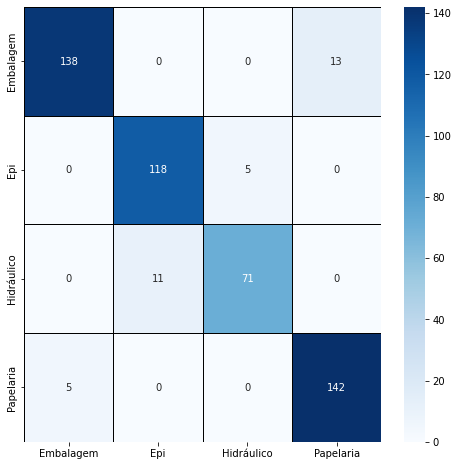

              precision    recall  f1-score   support

   Embalagem       0.97      0.91      0.94       151
         Epi       0.91      0.96      0.94       123
  Hidráulico       0.93      0.87      0.90        82
   Papelaria       0.92      0.97      0.94       147

    accuracy                           0.93       503
   macro avg       0.93      0.93      0.93       503
weighted avg       0.93      0.93      0.93       503

CPU times: total: 12min 15s
Wall time: 3min 25s


In [18]:
%%time

params = {}

# Tuning 03 Catboost
modelo_cat = CatBoostClassifier(iterations = 1250, learning_rate = 0.2, eval_metric = 'MultiClass',\
                                metric_period = 50, verbose = False, random_seed = seed_)

modelo_cat = treinaClassificacao_GridSearchCV(modelo_cat, params, X_train_tfidf, y_train,\
                                              X_test_tfidf, y_test, retorna_modelo = True)

In [32]:
modelo_cat.save_model('models/catboost.model')

In [19]:
# Salvando modelo como pickle
with open('models/catboost.pkl', 'wb') as model_file:
    pickle.dump(modelo_cat, model_file)